In [1]:
import polars as pl
from pymongo import MongoClient
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import contextily as ctx
from ydata_profiling import ProfileReport

In [2]:
# Conectar a MongoDB
client = MongoClient("mongodb://localhost:27017/")
database = client["ETIB_TFM"]
collection = database["transactions"]

In [3]:
# Rango de fechas
start_date = datetime(2024, 11, 11)
end_date = datetime(2024, 11, 18)

# Obtener los datos de MongoDB
query = {"Fecha_Transaccion": {"$gte": start_date, "$lt": end_date}}
cursor = collection.find(query)

# Convertir los datos a un DataFrame de Polars
df_polars = pl.DataFrame(cursor)

# Mostrar las primeras filas del DataFrame
print(df_polars.head())

shape: (5, 23)
┌────────────────┬─────────────┬────────────────┬────────────────┬───┬───────────────┬────────┬───────────────┬────────┐
│ _id            ┆ Dispositivo ┆ Emisor         ┆ Estacion_Parad ┆ … ┆ Tipo_Vehiculo ┆ Valor  ┆ archivo       ┆ cenefa │
│ ---            ┆ ---         ┆ ---            ┆ a              ┆   ┆ ---           ┆ ---    ┆ ---           ┆ ---    │
│ object         ┆ str         ┆ str            ┆ ---            ┆   ┆ str           ┆ f64    ┆ str           ┆ str    │
│                ┆             ┆                ┆ str            ┆   ┆               ┆        ┆               ┆        │
╞════════════════╪═════════════╪════════════════╪════════════════╪═══╪═══════════════╪════════╪═══════════════╪════════╡
│ 67471e1df909cb ┆ 220004413   ┆ (3101000)      ┆ (52973) 045A06 ┆ … ┆ (02) Urbano   ┆ 0.0    ┆ Validacion_01 ┆ 045A06 │
│ e620eb3347     ┆             ┆ Bogota         ┆ _TM|045A06_Br. ┆   ┆               ┆        ┆ 7_E-SOMOS     ┆        │
│                

In [4]:
df_polars = df_polars.with_columns([
    pl.col('Fecha_Transaccion').dt.hour().alias('Hora'),
    pl.col('Fecha_Transaccion').dt.weekday().alias('Dia_Semana'),  # 0=lunes, 6=domingo
    pl.col('Fecha_Transaccion').dt.date().alias('Fecha')
])

In [5]:
# 1. Análisis de demanda por hora (picos de demanda)
demanda_por_hora = df_polars.group_by('Hora').agg([
    pl.count().alias('Numero_Transacciones')
]).sort('Numero_Transacciones', descending=True)

C:\Users\Gabo0\AppData\Local\Temp\ipykernel_1464\3226129343.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('Numero_Transacciones')


In [6]:
# Mostrar los picos de demanda por hora
print("Demanda por hora del día:")
print(demanda_por_hora)

Demanda por hora del día:
shape: (24, 2)
┌──────┬──────────────────────┐
│ Hora ┆ Numero_Transacciones │
│ ---  ┆ ---                  │
│ i8   ┆ u32                  │
╞══════╪══════════════════════╡
│ 6    ┆ 1001329              │
│ 17   ┆ 852590               │
│ 7    ┆ 845777               │
│ 16   ┆ 748849               │
│ 5    ┆ 737468               │
│ …    ┆ …                    │
│ 23   ┆ 28693                │
│ 3    ┆ 19796                │
│ 0    ┆ 3225                 │
│ 1    ┆ 285                  │
│ 2    ┆ 110                  │
└──────┴──────────────────────┘


In [7]:
# 2. Análisis de demanda por día de la semana (identificar los días de mayor demanda)
demanda_por_dia = df_polars.group_by('Dia_Semana').agg([
    pl.count().alias('Numero_Transacciones')
]).sort('Numero_Transacciones', descending=True)

C:\Users\Gabo0\AppData\Local\Temp\ipykernel_1464\533981743.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('Numero_Transacciones')


In [8]:
print("Demanda por día de la semana:")
print(demanda_por_dia)

Demanda por día de la semana:
shape: (7, 2)
┌────────────┬──────────────────────┐
│ Dia_Semana ┆ Numero_Transacciones │
│ ---        ┆ ---                  │
│ i8         ┆ u32                  │
╞════════════╪══════════════════════╡
│ 3          ┆ 2071261              │
│ 2          ┆ 2064361              │
│ 5          ┆ 2044481              │
│ 4          ┆ 2041624              │
│ 6          ┆ 1444344              │
│ 7          ┆ 817947               │
│ 1          ┆ 769207               │
└────────────┴──────────────────────┘


In [9]:
# 3. Análisis de la congestión por ruta (rutas más congestionadas)
demanda_por_ruta = df_polars.group_by('Ruta').agg([
    pl.count().alias('Numero_Transacciones'),
    pl.sum('Valor').alias('Valor_Total')
]).sort('Numero_Transacciones', descending=True)

print("Rutas con mayor número de transacciones:")
print(demanda_por_ruta)

C:\Users\Gabo0\AppData\Local\Temp\ipykernel_1464\3956742158.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('Numero_Transacciones'),


Rutas con mayor número de transacciones:
shape: (673, 3)
┌─────────────────────────────────┬──────────────────────┬─────────────┐
│ Ruta                            ┆ Numero_Transacciones ┆ Valor_Total │
│ ---                             ┆ ---                  ┆ ---         │
│ str                             ┆ u32                  ┆ f64         │
╞═════════════════════════════════╪══════════════════════╪═════════════╡
│ (7067) T13_20220711_Ida_V3      ┆ 93880                ┆ 2.1211835e8 │
│ (8257) 94_20241028_V5           ┆ 81960                ┆ 1.82563e8   │
│ (4992) T11_20201109_Ida_SN_V1   ┆ 77510                ┆ 1.558912e8  │
│ (8164) SE6_20240826_V4          ┆ 75046                ┆ 1.589681e8  │
│ (4509) 740_20201013_V1          ┆ 74445                ┆ 1.612265e8  │
│ …                               ┆ …                    ┆ …           │
│ (10006) 17-3_Cierre             ┆ 1                    ┆ 0.0         │
│ (10358) 3-14 Uval Cierre        ┆ 1                    ┆ 0.0     

In [10]:
# 4. Análisis de demanda por hora y ruta para identificar congestión en picos específicos
demanda_por_hora_y_ruta = df_polars.group_by(['Hora', 'Ruta']).agg([
    pl.count().alias('Numero_Transacciones')
]).sort(['Hora', 'Numero_Transacciones'], descending=True)

print("Demanda por hora y ruta:")
print(demanda_por_hora_y_ruta)

C:\Users\Gabo0\AppData\Local\Temp\ipykernel_1464\2782864105.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('Numero_Transacciones')


Demanda por hora y ruta:
shape: (11_316, 3)
┌──────┬────────────────────────────────┬──────────────────────┐
│ Hora ┆ Ruta                           ┆ Numero_Transacciones │
│ ---  ┆ ---                            ┆ ---                  │
│ i8   ┆ str                            ┆ u32                  │
╞══════╪════════════════════════════════╪══════════════════════╡
│ 23   ┆ (5813) 634_20210417_V1         ┆ 558                  │
│ 23   ┆ (7071) CA117_20220628_V3       ┆ 481                  │
│ 23   ┆ (10893) HC705                  ┆ 433                  │
│ 23   ┆ (7011) 367_20220522_V3         ┆ 372                  │
│ 23   ┆ (5224) 192_20201219_V2         ┆ 370                  │
│ …    ┆ …                              ┆ …                    │
│ 0    ┆ (5447) 11-4_20210306_V1        ┆ 1                    │
│ 0    ┆ (5479) 11-10_20210306_V1       ┆ 1                    │
│ 0    ┆ (7906) 56A_20231211_V3         ┆ 1                    │
│ 0    ┆ (6120) C509_20210525_Ida_SN_V3 ┆ 1   

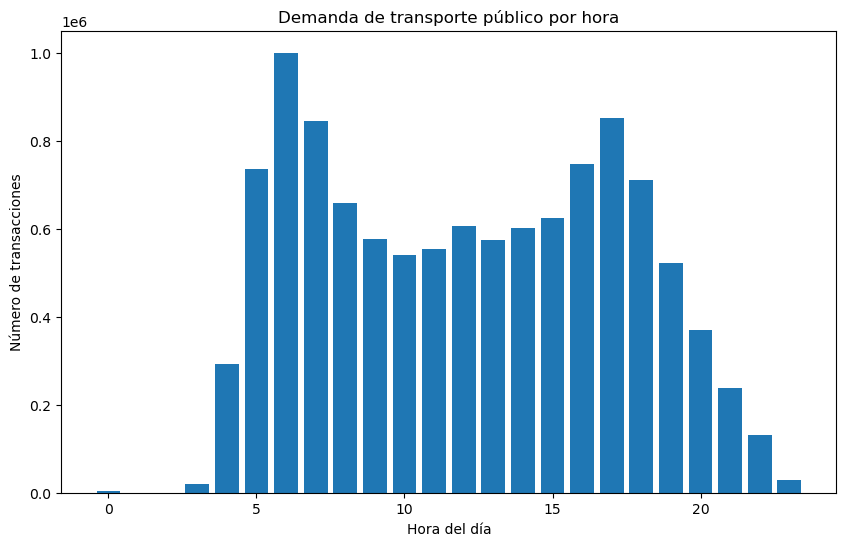

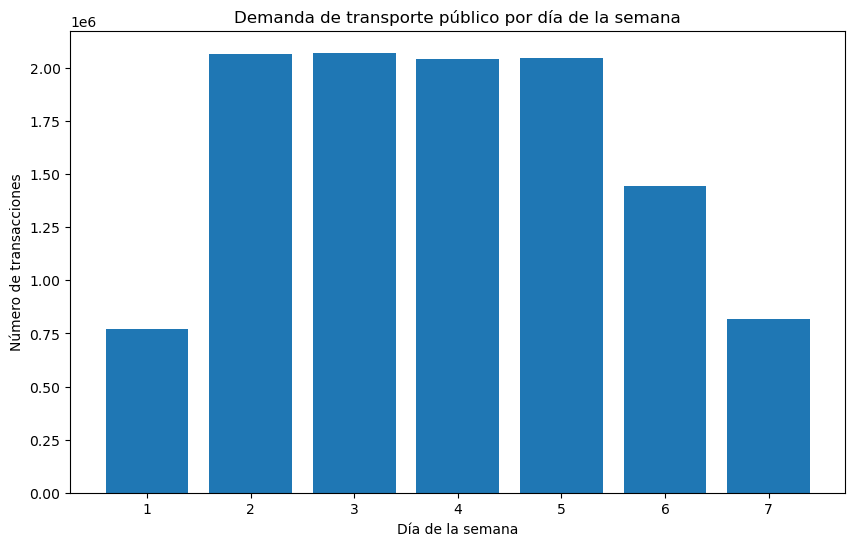

In [11]:
# 5. Visualización opcional (puedes usar librerías como matplotlib o seaborn para graficar)
import matplotlib.pyplot as plt

# Graficar la demanda por hora
plt.figure(figsize=(10, 6))
plt.bar(demanda_por_hora['Hora'], demanda_por_hora['Numero_Transacciones'])
plt.xlabel('Hora del día')
plt.ylabel('Número de transacciones')
plt.title('Demanda de transporte público por hora')
plt.show()

# Graficar la demanda por día de la semana
plt.figure(figsize=(10, 6))
plt.bar(demanda_por_dia['Dia_Semana'], demanda_por_dia['Numero_Transacciones'])
plt.xlabel('Día de la semana')
plt.ylabel('Número de transacciones')
plt.title('Demanda de transporte público por día de la semana')
plt.show()

In [12]:
df_pandas = df_polars.to_pandas()
df_pandas['Hora'] = df_pandas['Hora'].astype(str)
df_pandas['Dia_Semana'] = df_pandas['Dia_Semana'].astype(str)
profile = ProfileReport(df_pandas, title="Profiling Report")
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
profile = ProfileReport(df_pandas, title="Profiling Report", minimal=True)
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]